In [120]:
from feature_engine.discretisers import EqualWidthDiscretiser, EqualFrequencyDiscretiser
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', None) # Print all columns to jupyter notebook

DATA_PATH = r'../data/credit.csv'
df = pd.read_csv(DATA_PATH)

numeric_cols = [
    'checking_amt',
    'duration',
    'credit_amount',
    'savings',
    'installment_commitment', # Don't think this is categorical
    'residence_since',
    'age',
    'existing_credits',
    'num_dependents'
] 
categorical_cols = list(set(df.columns) - set(numeric_cols))


"""
Remove bad data - Quick removal of rows that contain garbage data
"""
# Remove where rows are almost entirely empty
df = df[df['location'] != '?'] # removes 2 rows
df = df[df['checking_amt'] != '?'] # removes 1 row





"""
Value renaming - structural modifications to data
"""

df['state'] = df['state'].replace('Rhodes Island', 'Rhode Island')

# 'location'
# Remove state abbrv in location. It is already stored in 'state' column
# and has been verified all rows have matching abbrv's and state columns.
df['location'] = df['location'].str.replace('District of Columbia', 'District of Columbia, DC')
df['location'] = df['location'].str.split(', ').apply(lambda x: x[0])

# 'property_magnitude'
# Replace the ?s with other and make format consistent.
df['property_magnitude'] = df['property_magnitude'].mask(df['property_magnitude'] == "?", "other")
df['property_magnitude'].replace("'(.*?)'", "\\1", inplace=True, regex=True)


# 'class', 'foreign_worker', 'works_outside_US'
# Make positive and negative values consistent
df['works_outside_US'].replace(['^(1|[Yy]).*', '^(0|[Nn]).*'], ['YES', 'NO'], inplace=True, regex=True)
df['foreign_worker'].replace(['^(1|[Yy]).*', '^(0|[Nn]).*'], ['YES', 'NO'], inplace=True, regex=True)
df['class'].replace(['^([Gg]).*', '^([Bb]).*'], ['GOOD', 'BAD'], inplace=True, regex=True)


# 'employment'
# Replacing missing employment values with unknown
df['employment'] = df['employment'].mask(df['employment'] == "?", "unknown")


# 'personal_status'
# Replacing missing personal_status values with unknown
df['personal_status'] = df['personal_status'].mask(df['personal_status'] == "?", "unknown")
# Remove the single quotes around the data
df['personal_status'].replace("'(.*?)'", "\\1", inplace=True, regex=True)


# 'other_parties'
# Replacing missing other_parties values with unknown
df['other_parties'] = df['other_parties'].mask(df['other_parties'] == "?", "unknown")
# Remove the single quotes around the data
df['other_parties'].replace("'(.*?)'", "\\1", inplace=True, regex=True)


# 'purpose'
# Replacing missing other_parties values with unknown
df['purpose'] = df['other_parties'].mask(df['purpose'] == "?", "unknown")
# Remove the single quotes around the data
df['purpose'].replace("'(.*?)'", "\\1", inplace=True, regex=True)


# 'job'
# Replacing missing other_parties values with unknown
df['job'].mask(df['job'] == "?", "unknown", inplace=True)
# Remove the single quotes around the data
df['job'].replace("'(.*?)'", "\\1", inplace=True, regex=True)




"""
Value manipulation - semantic modifications to data
"""

# 'checking_amt'
# Bin into 10 equal width bins
df['checking_amt'] = df['checking_amt'].apply(float) # Stored as strings originally
df = df[df['checking_amt'].isna() != True] # removes 1 row
eqdist_discretiser = EqualWidthDiscretiser(
    bins=10, 
    variables=['checking_amt']
)
df = eqdist_discretiser.fit_transform(df)


# 'age'
# Remove rows with unrealistic ages
no_miss_age = df[df['age'] != "?"]
no_miss_age = no_miss_age.astype({"age": int})
# Remove outliers and then calculate the average value
no_miss_age = no_miss_age[no_miss_age.between(0, 100)]
mean = int(no_miss_age['age'].mean())
# Replace all ?s with the calculate average, also remove the outliers again
df['age'] = df['age'].mask(df['age'] == "?", f"{mean}")
df = df.astype({"age": int})
df = df[df['age'].between(0, 100)]


# 'num_dependents'
# Set ?'s to median value, remove unrealistic values
median = df[df['num_dependents'] != '?']['num_dependents'].apply(int).median()
df['num_dependents'].mask(df['num_dependents'] == "?", median, inplace=True)
df['num_dependents'] = df['num_dependents'].apply(int)
df = df[df['num_dependents'].between(0, 5)]
    
    
# Status of cleaning for each the column

# location                # Done
# state                   # Done
# checking_amt            # binned, want opinion
# duration                # TODO 89 '?'s, will get to later
# credit_history
# purpose
# credit_amount         # Done, added average as replacement for missing. Maybe bin?
# savings
# employment            # Done
# installment_commitment
# personal_status       # Done
# other_parties         # Done
# residence_since       
# property_magnitude    # Done, destringified and added "other"
# age                   # Done, replaced outliers with mean of column, filtered out outliers, maybe bin?
# other_payment_plans
# housing
# existing_credits
# job                   # Done, replaced ? with unknown
# num_dependents        # Done, Removed bad data. Replaced ? with median
# own_telephone         # 117 ?'s, TODO
# foreign_worker        # Done, made yes/no input consistent.
# class                 # Done, made good/bad input consistent.
# verified              # 995 verified, 3 yes, 2 no. Probably should just drop this.
# application_date      # Done. Want opinion. Format as ordinal time or make month/year cols?
# works_outside_US      # Done, made yes/no input consistent.



TypeError: '>=' not supported between instances of 'str' and 'int'

In [22]:
df

,location,state,checking_amt,duration,credit_history,purpose,credit_amount,savings,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,verified,application_date,works_outside_US
0,"Lehigh, PA",Pennsylvania,-2589.19,6,'critical/other existing credit',radio/tv,?,0,>=7,?,'male single',none,4,'real estate',67,none,own,2,skilled,1,yes,NO,BAD,?,May-07-1994,NO
1,"Mifflin, PA",Pennsylvania,53.51,48,'existing paid',radio/tv,5951,2.52,1<=X<4,2,'female div/dep/mar',none,2,?,22,none,own,1,skilled,1,none,NO,BAD,?,May-08-1994,NO
2,"Northampton, PA",Pennsylvania,0.00,12,'critical/other existing credit',education,2096,0,4<=X<7,2,'male single',?,?,'real estate',49,none,?,1,'unskilled resident',2,none,NO,BAD,?,5/9/1994,NO
3,"Northampton, PA",Pennsylvania,-4695.81,42,'existing paid',furniture/equipment,7882,92.15,4<=X<7,2,'male single',guarantor,4,'life insurance',45,none,'for free',1,skilled,2,?,NO,BAD,?,5/10/1994,NO
4,"Westmoreland, PA",Pennsylvania,-9540.20,24,'delayed previously',?,4870,39.81,1<=X<4,3,'male single',none,4,'no known property',53,none,'for free',2,skilled,2,none,NO,GOOD,?,5/11/1994,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,"Nassau, NY",New York,0.00,12,'existing paid',furniture/equipment,1736,0,4<=X<7,3,?,none,4,'real estate',31,none,own,1,'unskilled resident',1,none,NO,BAD,?,1/30/1997,NO
1000,"New York, NY",New York,-3296.07,30,'existing paid',?,3857,88.42,1<=X<4,4,'male div/sep',none,4,'life insurance',40,none,own,1,'high qualif/self emp/mgmt',1,yes,YES,GOOD,?,1/31/1997,YES
1001,"Butler, OH",Ohio,0.00,?,'existing paid',radio/tv,804,0,>=7,4,'male single',?,4,car,38,none,own,1,skilled,1,none,NO,GOOD,?,Feb-01-1997,NO
1002,"Clark, OH",Ohio,-7050.13,45,'existing paid',radio/tv,1845,66.53,1<=X<4,4,'male single',?,?,'no known property',23,none,'for free',1,skilled,?,yes,YES,GOOD,?,Feb-02-1997,YES


In [144]:
"""
In main script.
"""

# abbrv_map = {
#     'AL': 'Alabama',
#     'AK': 'Alaska',
#     'AZ': 'Arizona',
#     'AR': 'Arkansas',
#     'CA': 'California',
#     'CO': 'Colorado',
#     'CT': 'Connecticut',
#     'DE': 'Delaware',
#     'DC': 'District of Columbia',
#     'FL': 'Florida',
#     'GA': 'Georgia',
#     'HI': 'Hawaii',
#     'ID': 'Idaho',
#     'IL': 'Illinois',
#     'IN': 'Indiana',
#     'IA': 'Iowa',
#     'KS': 'Kansas',
#     'KY': 'Kentucky',
#     'LA': 'Louisiana',
#     'ME': 'Maine',
#     'MD': 'Maryland',
#     'MA': 'Massachusetts',
#     'MI': 'Michigan',
#     'MN': 'Minnesota',
#     'MS': 'Mississippi',
#     'MO': 'Missouri',
#     'MT': 'Montana',
#     'NE': 'Nebraska',
#     'NV': 'Nevada',
#     'NH': 'New Hampshire',
#     'NJ': 'New Jersey',
#     'NM': 'New Mexico',
#     'NY': 'New York',
#     'NC': 'North Carolina',
#     'ND': 'North Dakota',
#     'OH': 'Ohio',
#     'OK': 'Oklahoma',
#     'OR': 'Oregon',
#     'PA': 'Pennsylvania',
#     'RI': 'Rhode Island',
#     'SC': 'South Carolina',
#     'SD': 'South Dakota',
#     'TN': 'Tennessee',
#     'TX': 'Texas',
#     'UT': 'Utah',
#     'VT': 'Vermont',
#     'VA': 'Virginia',
#     'WA': 'Washington',
#     'WV': 'West Virginia',
#     'WI': 'Wisconsin',
#     'WY': 'Wyoming'
# }

# def seperate_locs(row):
#     """
#     This was to verify that every location entry had matching state data.
#     Long story short they did, so this is not actually needed.
#     """
#     try:
#         loc, state_abbrv = row['location'].split(', ')
#     except Exception as e:
#         print(row['location'])
#         raise e
#     row['abbrv'] = abbrv_map[state_abbrv]
#     row['location'] = loc
#     return row['location']
# df['abbrv'] = df.apply(seperate_locs, axis=1)


df['location'] = df['location'].str.replace('District of Columbia', 'District of Columbia, DC')
df['location'] = df['location'].str.split(', ').apply(lambda x: x[0])

array([[<AxesSubplot:title={'center':'checking_amt'}>]], dtype=object)

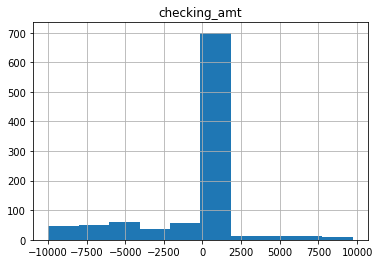

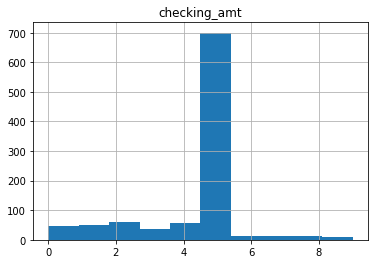

In [14]:
"""
In main script
"""
from feature_engine.discretisers import EqualWidthDiscretiser, EqualFrequencyDiscretiser
import matplotlib.pyplot as plt
df['checking_amt'] = df['checking_amt'].apply(float) # Stored as strings originally
df.hist(column='checking_amt') # Display raw values


# Binning is the way to go? Right now I have equal width.
# Equal frequency maybe? But I don't think so with the distribution
eqdist_discretiser = EqualWidthDiscretiser(
    bins=10, 
    variables=['checking_amt']
)
df = eqdist_discretiser.fit_transform(df)

df.hist(column='checking_amt')


In [119]:
df['savings'].apply(float).describe()

count    1000.000000
mean      147.482050
std       816.666861
min         0.000000
25%         0.000000
50%         0.000000
75%        51.137500
max      9298.080000
Name: savings, dtype: float64

In [106]:
# df[df['own_telephone'] == 'yes']
df['own_telephone'].value_counts()

none    526
yes     357
?       117
Name: own_telephone, dtype: int64

In [2]:
# Replace the ?s with other
df['property_magnitude'] = df['property_magnitude'].mask(df['property_magnitude'] == "?", "other")
# Remove the single quotes around the data
df['property_magnitude'].replace("'(.*?)'", "\\1", inplace=True, regex=True)
# Display the values as a sanity check
df['property_magnitude'].value_counts()

car                  297
real estate          262
life insurance       211
no known property    137
other                 93
Name: property_magnitude, dtype: int64

In [50]:
"""
In main script
"""
# Grab the age column without ?s
no_miss_age = df[df['age'] != "?"]
# Convert to integer
no_miss_age = no_miss_age.astype({"age": int})
# Remove outliers and then calculate the average value
no_miss_age = no_miss_age[no_miss_age['age'] < 100]
no_miss_age = no_miss_age[no_miss_age['age'] > 0]
mean = int(no_miss_age['age'].mean())

# Remove all ?s with the calculate average, also remove the outliers again
df['age'] = df['age'].mask(df['age'] == "?", f"{mean}")

df = df.astype({"age": int})
df = df[df['age'] < 100]
df = df[df['age'] > 0]
df['age'].value_counts()

35    142
23     46
26     43
24     41
27     41
25     39
28     39
30     36
29     35
36     34
31     34
33     31
32     31
34     30
40     25
37     25
38     23
22     19
39     18
42     18
47     16
41     15
43     15
44     14
20     14
45     13
46     13
21     13
49     12
48     11
50     10
57      9
54      8
61      7
63      7
51      7
60      6
52      6
55      6
64      5
65      5
58      5
53      4
56      3
66      3
67      3
68      3
75      2
74      2
59      2
62      2
19      2
70      1
Name: age, dtype: int64

In [ ]:
"""
In main script
"""
# Replacing missing employment values with unknown
df['employment'] = df['employment'].mask(df['employment'] == "?", "unknown")

In [ ]:
"""
In main script
"""

# Replacing missing personal_status values with unknown
df['personal_status'] = df['personal_status'].mask(df['personal_status'] == "?", "unknown")
# Remove the single quotes around the data
df['personal_status'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

In [ ]:
"""
In main script
"""
# Replacing missing other_parties values with unknown
df['other_parties'] = df['other_parties'].mask(df['other_parties'] == "?", "unknown")
# Remove the single quotes around the data
df['other_parties'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

In [53]:
# Clean up the date to follow standard datetime format
df['application_date']= pd.to_datetime(df['application_date']) 

0       May-07-1994
1       May-08-1994
2          5/9/1994
3         5/10/1994
4         5/11/1994
           ...     
999       1/30/1997
1000      1/31/1997
1001    Feb-01-1997
1002    Feb-02-1997
1003    Feb-03-1997
Name: application_date, Length: 1000, dtype: object

In [59]:
# Grab the credit_amount column without ?s
no_miss_credit = df[df['credit_amount'] != "?"]
# Convert to integer
no_miss_credit = no_miss_credit.astype({"credit_amount": float})
# Remove outliers and then calculate the average value
mean = float(no_miss_credit['credit_amount'].mean())

# Remove all ?s with the calculate average, also remove the outliers again
df['credit_amount'] = df['credit_amount'].mask(df['credit_amount'] == "?", f"{mean}")
df = df.astype({"credit_amount": float})

,location,state,checking_amt,duration,credit_history,purpose,credit_amount,savings,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,verified,application_date,works_outside_US
0,"Lehigh, PA",Pennsylvania,-2589.19,6,'critical/other existing credit',radio/tv,3234.553431,0,>=7,?,'male single',none,4,'real estate',67,none,own,2,skilled,1,yes,NO,BAD,?,May-07-1994,NO
1,"Mifflin, PA",Pennsylvania,53.51,48,'existing paid',radio/tv,5951.000000,2.52,1<=X<4,2,'female div/dep/mar',none,2,?,22,none,own,1,skilled,1,none,NO,BAD,?,May-08-1994,NO
2,"Northampton, PA",Pennsylvania,0.00,12,'critical/other existing credit',education,2096.000000,0,4<=X<7,2,'male single',?,?,'real estate',49,none,?,1,'unskilled resident',2,none,NO,BAD,?,5/9/1994,NO
3,"Northampton, PA",Pennsylvania,-4695.81,42,'existing paid',furniture/equipment,7882.000000,92.15,4<=X<7,2,'male single',guarantor,4,'life insurance',45,none,'for free',1,skilled,2,?,NO,BAD,?,5/10/1994,NO
4,"Westmoreland, PA",Pennsylvania,-9540.20,24,'delayed previously',?,4870.000000,39.81,1<=X<4,3,'male single',none,4,'no known property',53,none,'for free',2,skilled,2,none,NO,GOOD,?,5/11/1994,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,"Nassau, NY",New York,0.00,12,'existing paid',furniture/equipment,1736.000000,0,4<=X<7,3,?,none,4,'real estate',31,none,own,1,'unskilled resident',1,none,NO,BAD,?,1/30/1997,NO
1000,"New York, NY",New York,-3296.07,30,'existing paid',?,3857.000000,88.42,1<=X<4,4,'male div/sep',none,4,'life insurance',40,none,own,1,'high qualif/self emp/mgmt',1,yes,YES,GOOD,?,1/31/1997,YES
1001,"Butler, OH",Ohio,0.00,?,'existing paid',radio/tv,804.000000,0,>=7,4,'male single',?,4,car,38,none,own,1,skilled,1,none,NO,GOOD,?,Feb-01-1997,NO
1002,"Clark, OH",Ohio,-7050.13,45,'existing paid',radio/tv,1845.000000,66.53,1<=X<4,4,'male single',?,?,'no known property',23,none,'for free',1,skilled,?,yes,YES,GOOD,?,Feb-02-1997,YES


In [ ]:
"""
In main script
"""
# Replacing missing other_parties values with unknown
df['purpose'] = df['other_parties'].mask(df['purpose'] == "?", "unknown")
# Remove the single quotes around the data
df['purpose'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

In [27]:
from datetime import date
from dateutil import parser
# Convert to consistent format, set to use ordinal time so it is continious
# Do we want that? Loses distinguishing info on month/year but makes continious
s = df['application_date'].apply(lambda x: parser.parse(x).date().toordinal())

# If we make continious we should also make normalize it.
s = (s - s.min())/(s.max() - s.min())

df['application_date'] = s


0       0.000000
1       0.000997
2       0.001994
3       0.002991
4       0.003988
          ...   
999     0.996012
1000    0.997009
1001    0.998006
1002    0.999003
1003    1.000000
Name: application_date, Length: 1000, dtype: float64

In [73]:
median = df[df['num_dependents'] != '?']['num_dependents'].apply(int).median()
df['num_dependents'].mask(df['num_dependents'] == "?", median, inplace=True)
df['num_dependents'] = df['num_dependents'].apply(int)
df = df[df['num_dependents'].between(0, 5)]
df.num_dependents.value_counts()

# print(known_vals.mean()) # 2093625.787444934
# known_vals = known_vals[known_vals >= 0]
# known_vals = known_vals[known_vals <= 5] # The highest valid value seemed to be 2, but 5 just for good measure
# # print(known_vals.mean()) # 1.1581858407079646
# # print(df[known_vals.index].shape)
# known_vals.median()


1    853
2    143
Name: num_dependents, dtype: int64

In [79]:
df['job'].value_counts()
# Replacing missing other_parties values with unknown
df['job'].mask(df['job'] == "?", "unknown", inplace=True)
# Remove the single quotes around the data
df['job'].replace("'(.*?)'", "\\1", inplace=True, regex=True)
df['job'].value_counts()

skilled                      574
unskilled resident           182
high qualif/self emp/mgmt    135
unknown                       87
unemp/unskilled non res       22
Name: job, dtype: int64

/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning:

array([[<AxesSubplot:title={'center':'checking_amt'}>,
        <AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'credit_amount'}>],
       [<AxesSubplot:title={'center':'savings'}>,
        <AxesSubplot:title={'center':'installment_commitment'}>,
        <AxesSubplot:title={'center':'residence_since'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'existing_credits'}>,
        <AxesSubplot:title={'center':'num_dependents'}>]], dtype=object)

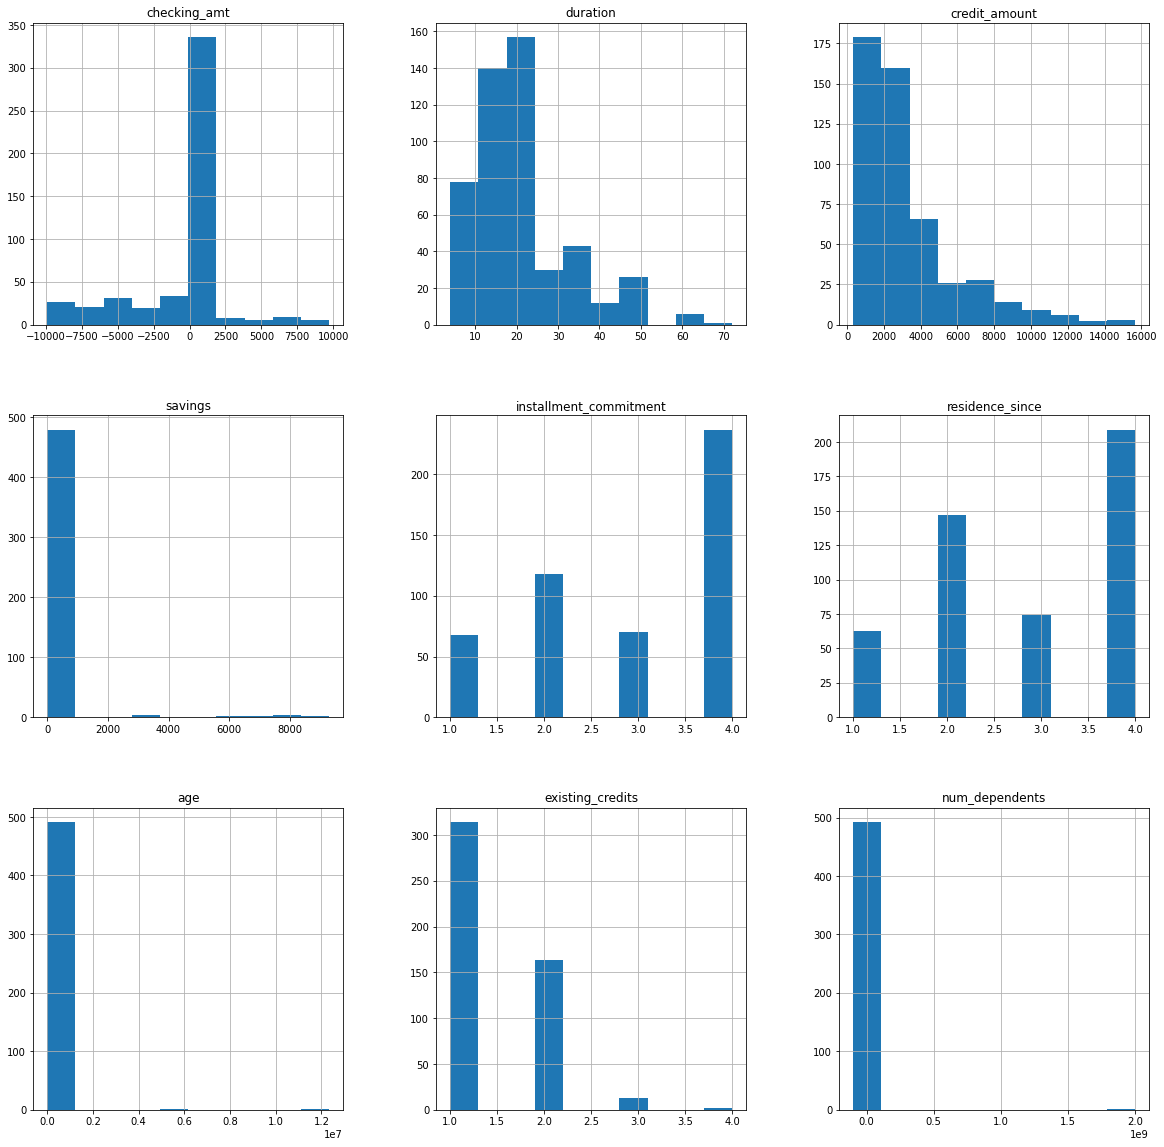

In [99]:
# This should NOT be run when we are finished
# This naively removes all '?'s just to see some graphs quickly
%matplotlib inline
for col in numeric_cols:
    df = df[df[col] != '?']
    df[col] = df[col].apply(float)
df.hist(figsize=(20,20))
    

array([[<AxesSubplot:xlabel='checking_amt', ylabel='checking_amt'>,
        <AxesSubplot:xlabel='duration', ylabel='checking_amt'>,
        <AxesSubplot:xlabel='credit_amount', ylabel='checking_amt'>,
        <AxesSubplot:xlabel='savings', ylabel='checking_amt'>,
        <AxesSubplot:xlabel='installment_commitment', ylabel='checking_amt'>,
        <AxesSubplot:xlabel='residence_since', ylabel='checking_amt'>,
        <AxesSubplot:xlabel='age', ylabel='checking_amt'>,
        <AxesSubplot:xlabel='existing_credits', ylabel='checking_amt'>,
        <AxesSubplot:xlabel='num_dependents', ylabel='checking_amt'>],
       [<AxesSubplot:xlabel='checking_amt', ylabel='duration'>,
        <AxesSubplot:xlabel='duration', ylabel='duration'>,
        <AxesSubplot:xlabel='credit_amount', ylabel='duration'>,
        <AxesSubplot:xlabel='savings', ylabel='duration'>,
        <AxesSubplot:xlabel='installment_commitment', ylabel='duration'>,
        <AxesSubplot:xlabel='residence_since', ylabel='duration

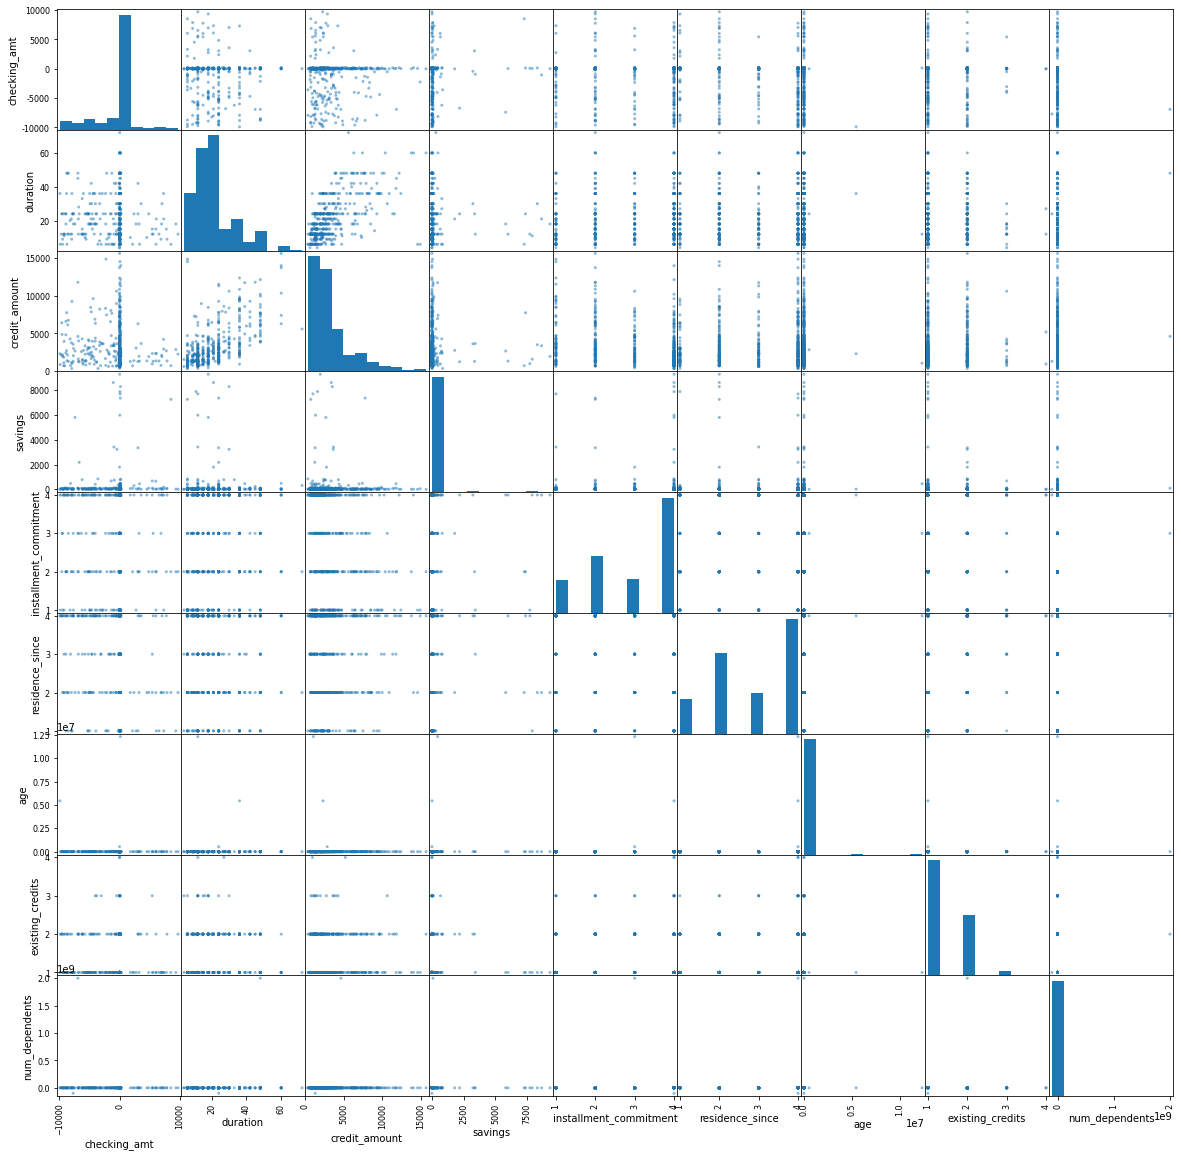

In [103]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[numeric_cols], figsize=(20,20))

In [104]:
df.corr()

,checking_amt,duration,credit_amount,savings,installment_commitment,residence_since,age,existing_credits,num_dependents
checking_amt,1.000000,-0.053076,-0.031641,0.049591,-0.004733,-0.148976,-0.038605,0.001899,-0.082934
duration,-0.053076,1.000000,0.611072,-0.036904,0.083659,0.023812,-0.007160,0.010021,0.100115
credit_amount,-0.031641,0.611072,1.000000,-0.036599,-0.292996,0.043565,-0.040480,0.025256,0.024708
savings,0.049591,-0.036904,-0.036599,1.000000,0.022489,-0.024552,0.005282,-0.075886,-0.005029
installment_commitment,-0.004733,0.083659,-0.292996,0.022489,1.000000,0.042083,0.018019,0.037606,-0.000693
residence_since,-0.148976,0.023812,0.043565,-0.024552,0.042083,1.000000,0.062752,0.034138,0.043811
age,-0.038605,-0.007160,-0.040480,0.005282,0.018019,0.062752,1.000000,-0.043283,-0.002620
existing_credits,0.001899,0.010021,0.025256,-0.075886,0.037606,0.034138,-0.043283,1.000000,0.049751
num_dependents,-0.082934,0.100115,0.024708,-0.005029,-0.000693,0.043811,-0.002620,0.049751,1.000000
